In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from quran_ir import FasttextQuranIR

sns.set();

100%|██████████| 6236/6236 [00:00<00:00, 13217.36it/s]


<div dir="rtl">
خواندن سوره‌های مکی و مدنی
<div>

In [2]:
maki = pd.read_csv('./data/مکی.csv').iloc[:, 0].apply(int).to_numpy()
madani = pd.read_csv('./data/مدنی.csv').iloc[:, 0].apply(int).to_numpy()
madani.sort()
maki.sort()

<div dir="rtl">
محاسبه‌ی بردار سوره‌ها از روی بردارهای آیات
<div>
<div dir="rtl">
ما روی ستون‌های مختلف (خود آیات، ریشه، لم) و همچنین جمعشان کل فرایند را تکرار کردیم و بهترین خروجی برای وقتی بود که خود آیات اصلی را خوشه‌بندی کنیم.
<div>

In [3]:
fasttext_quran_ir = FasttextQuranIR()
# X = fasttext_quran_ir.merged_corpus_embeddings.sum(axis=1).to_frame()
X = fasttext_quran_ir.merged_corpus_embeddings[['original_normalized']]
X['شماره سوره'] = X.index.to_series().str.split('##').apply(lambda x: int(x[0]))
X = X.groupby(['شماره سوره']).sum()
X_type = pd.DataFrame(data={'نوع سوره': 'مکی'}, index=X.index)
X_type.loc[X_type.index.isin(madani), 'نوع سوره'] = 'مدنی'
X_type = X_type.reset_index()
X = np.array(X.iloc[:,0].to_list())
X = sklearn.preprocessing.normalize(X, axis=1, norm='l2')

/Users/jarrahi_mm/Documents/Open_Projects/quran_mir/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/n3/y9f3rhhs77xbgwt7hl3rg0_00000gn/T/ipykernel_22136/86571369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['شماره سوره'] = X.index.to_series().str.split('##').apply(lambda x: int(x[0]))


# PCA

<div dir="rtl">
رسم نمودار سوره‌ها به کمک روش کاهش ابعاد PCA
<div>

original shape:    (114, 100)
transformed shape: (114, 2)


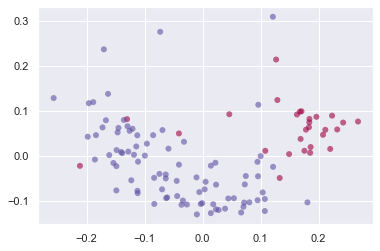

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=(X_type['نوع سوره'] == 'مکی').to_list(), edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.show()

# t-SNE


<div dir="rtl">
رسم نمودار سوره‌ها به کمک روش کاهش ابعاد t-SNE
<div>

/Users/jarrahi_mm/Documents/Open_Projects/quran_mir/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jarrahi_mm/Documents/Open_Projects/quran_mir/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


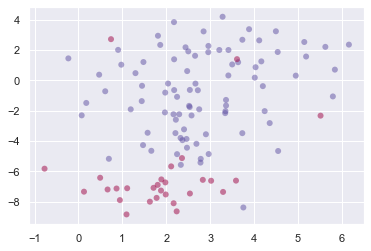

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
            c=(X_type['نوع سوره'] == 'مکی').to_list(), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.show()

# K-means


<div dir="rtl">
استفاده از روش K-means برای خوشه‌بندی سوره‌ها به دو خوشه<div>

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init=200, max_iter=1000).fit(X)
kmeans_labels = kmeans.labels_

<div dir="rtl">
ارزیابی خوشه‌بندی و مقایسه با خوشه‌ی مکی/مدنی به روش‌های مختلف از جمله RSS و Purity که در اسلایدها بودند و همچنین چند روش دیگر.
<div>

In [7]:
# RSS , the squared distance of each vector from its centroid summed over all vectors
centers = kmeans.cluster_centers_[kmeans_labels]
rss = np.sum((X - centers) ** 2, axis=1).sum()
print(f'{"RSS manual:":<80} {rss:.4f}')
print(f'{"RSS auto:":<80} {-kmeans.score(X):.4f}')

contingency_matrix = sklearn.metrics.cluster.contingency_matrix(X_type['نوع سوره'] == 'مدنی', kmeans_labels)
y_true, y_pred = X_type["نوع سوره"] == "مدنی", kmeans_labels
print(f'{"Purity:":<80} {np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix):.4f}')
print(f'{"accuracy_score:":<80} {sklearn.metrics.accuracy_score(y_true, y_pred):.4f}')
print(f'{"balanced_accuracy_score:":<80} {sklearn.metrics.balanced_accuracy_score(y_true, y_pred):.4f}')
print(
    f'{"fowlkes_mallows_score (The score ranges from 0 to 1):":<80} {sklearn.metrics.fowlkes_mallows_score(y_true, y_pred):.4f}')
print(f'{"rand_score (Score between 0.0 and 1.0):":<80} {sklearn.metrics.rand_score(y_true, y_pred):.4f}')

RSS manual:                                                                      10.7932
RSS auto:                                                                        10.7932
Purity:                                                                          0.8158
accuracy_score:                                                                  0.8158
balanced_accuracy_score:                                                         0.8418
fowlkes_mallows_score (The score ranges from 0 to 1):                            0.7396
rand_score (Score between 0.0 and 1.0):                                          0.6968


<div dir="rtl">
در نمودار زیر، ستاره‌ها کلاس مکی و مربع‌ها کلاس مدنی هستند.
     رنگ سرمه‌ای به این معنی است که خوشه‌ی پیدا شده معادل صحیحی است. و رنگ‌ها صورتی به معنای خوشه‌های نامعادل هستند.
دایره‌های مشکی نیز مراکز انتخابی در روش K-means است.
همان‌طور که می‌بینید سمت راست صفحه به عنوان خوشه ۱ و یا به عبارتی مدنی و سمت چپ صفحه به عنوان خوشه ۲ و یا به عبارتی مکی در نظر گرفته شده است. حال اگر یک سوره مکی در سمت راست صفحه باشد، به شکل ستاره‌ی صورتی خواهد بود که نشان‌دهنده عدم تطابق است.
<div>

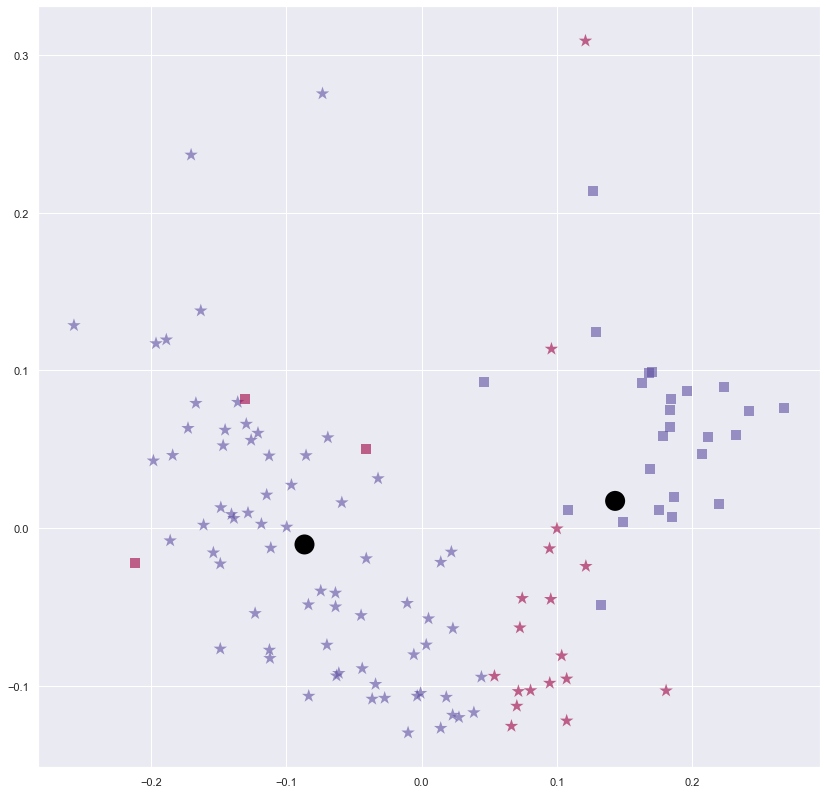

In [8]:
plt.figure(figsize=(14,14))

selection = (X_type['نوع سوره'] == 'مکی')
plt.scatter(X_pca[selection, 0], X_pca[selection, 1],
            c=(kmeans_labels[selection] == 0), edgecolor='none', alpha=0.6, s=200,
            marker='*',
            cmap=plt.cm.get_cmap('Spectral', 10))

selection = (X_type['نوع سوره'] == 'مدنی')
plt.scatter(X_pca[selection, 0], X_pca[selection, 1],
            c=(kmeans_labels[selection] == 1), edgecolor='none', alpha=0.6, s=100,
            marker=',',
            cmap=plt.cm.get_cmap('Spectral', 10))

centers_low_dim=pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_low_dim[:,0], centers_low_dim[:,1],
            c='black', edgecolor='none', alpha=1, s=400,
            marker='o')

plt.show()